# Seq2seq LSTM

## Import packages

In [2]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import math

import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

%matplotlib inline

In [3]:
# set random state

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Define Dataloader

In [4]:
ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [5]:
torch.cuda.current_device()

0

In [6]:
!nvidia-smi

Mon May 30 14:51:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   36C    P8     8W / 250W |      3MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Define the Seq2Seq Model

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.seq_len = input_dim[0]
        self.inp_feat_dim = input_dim[1]
        self.n_layers = n_layers
        
        
        self.lstm = nn.LSTM(input_size = self.inp_feat_dim, hidden_size = hid_dim, num_layers = n_layers, 
                            dropout = dropout, batch_first = True)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp):
    
        #input = [batch size, inp len, feat dim]
        
        outputs, (hidden, cell) = self.lstm(inp)
        
        #outputs = [batch size, src len, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [8]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout = 0.0):
        super().__init__()
        
        self.output_dim = output_dim # 2 for (x,y)
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        
        self.lstm = nn.LSTM(output_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, feat_size]
                
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = torch.Size([128, 50, 2])
        #trg = torch.Size([128, 60, 2])
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_feat_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_feat_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the input's first point * batch size
        input = src[:,49,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:,t,:] if teacher_force else output
        
        
        #transpose the matrix's and dimension to use old csv output pipeline
        outputs = outputs.transpose(1,0)
        
        return outputs

## Training the Seq2Seq Model

#### 1. "Teacher-forcing" = 0.0 & 2 layers

In [9]:
INPUT_DIM = (50,2)
OUTPUT_DIM = 2
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.0 #0.3
DEC_DROPOUT = 0.0 #0.3

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(2, 512, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (decoder): Decoder(
    (lstm): LSTM(2, 512, num_layers=2)
    (fc_out): Linear(in_features=512, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,317,058 trainable parameters


In [12]:
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [13]:
criterion = nn.MSELoss()

In [14]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        src, trg = batch
        
        src = src.to(device)
        src = src.float()
        trg = trg.to(device)
        trg = trg.float()
            
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [batch size, trg len, trg feat]
        #output = [batch size, trg len, out dim]    
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [15]:
def evaluate(model, val_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()
            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(val_loader)


In [16]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

city: austin
Epoch: 01
	Train Loss: 1875465.420 | Val. Loss: 1639525.026
Epoch: 02
	Train Loss: 1475498.186 | Val. Loss: 1339074.087
Epoch: 03
	Train Loss: 1254497.237 | Val. Loss: 1181582.897
Epoch: 04
	Train Loss: 1116777.163 | Val. Loss: 1065199.811
Epoch: 05
	Train Loss: 1009701.675 | Val. Loss: 967596.191
Epoch: 06
	Train Loss: 922580.460 | Val. Loss: 887388.029
Epoch: 07
	Train Loss: 848076.502 | Val. Loss: 828496.642
Epoch: 08
	Train Loss: 792863.210 | Val. Loss: 771309.965
Epoch: 09
	Train Loss: 738204.900 | Val. Loss: 717382.909
Epoch: 10
	Train Loss: 688915.082 | Val. Loss: 673558.140
Epoch: 11
	Train Loss: 645495.206 | Val. Loss: 631666.062
Epoch: 12
	Train Loss: 598743.136 | Val. Loss: 583001.771
Epoch: 13
	Train Loss: 555120.393 | Val. Loss: 540046.179
Epoch: 14
	Train Loss: 509853.614 | Val. Loss: 501412.146
Epoch: 15
	Train Loss: 471555.379 | Val. Loss: 460282.067
Epoch: 16
	Train Loss: 434643.282 | Val. Loss: 427488.659
Epoch: 17
	Train Loss: 402733.588 | Val. Loss: 393

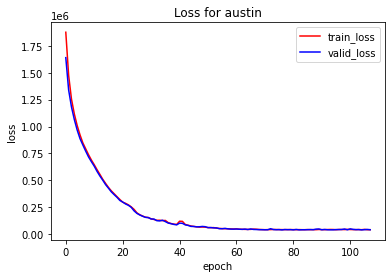

city: miami
Epoch: 01
	Train Loss: 1370435.021 | Val. Loss: 921879.140
Epoch: 02
	Train Loss: 773849.986 | Val. Loss: 678280.601
Epoch: 03
	Train Loss: 581847.930 | Val. Loss: 513936.452
Epoch: 04
	Train Loss: 479255.542 | Val. Loss: 453519.004
Epoch: 05
	Train Loss: 435629.443 | Val. Loss: 417797.135
Epoch: 06
	Train Loss: 415291.864 | Val. Loss: 397683.078
Epoch: 07
	Train Loss: 381387.772 | Val. Loss: 377549.154
Epoch: 08
	Train Loss: 375538.520 | Val. Loss: 433293.222
Epoch: 09
	Train Loss: 359938.228 | Val. Loss: 345097.282
Epoch: 10
	Train Loss: 356751.616 | Val. Loss: 351073.391
Epoch: 11
	Train Loss: 352580.051 | Val. Loss: 354014.236
Epoch: 12
	Train Loss: 340665.252 | Val. Loss: 385141.493
Epoch: 13
	Train Loss: 350843.271 | Val. Loss: 330598.497
Epoch: 14
	Train Loss: 325478.785 | Val. Loss: 304184.101
Epoch: 15
	Train Loss: 319801.493 | Val. Loss: 315222.712
Epoch: 16
	Train Loss: 312608.048 | Val. Loss: 300782.835
Epoch: 17
	Train Loss: 299865.666 | Val. Loss: 337663.984
E

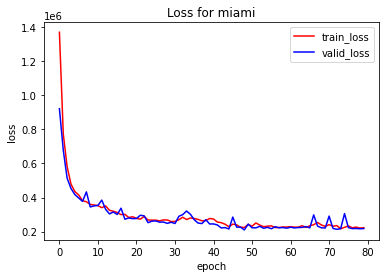

city: pittsburgh
Epoch: 01
	Train Loss: 251521.578 | Val. Loss: 219159.554
Epoch: 02
	Train Loss: 196237.864 | Val. Loss: 179174.179
Epoch: 03
	Train Loss: 184846.845 | Val. Loss: 201860.384
Epoch: 04
	Train Loss: 179386.692 | Val. Loss: 174638.370
Epoch: 05
	Train Loss: 183223.616 | Val. Loss: 176624.567
Epoch: 06
	Train Loss: 177329.088 | Val. Loss: 183496.683
Epoch: 07
	Train Loss: 169684.999 | Val. Loss: 173482.315
Epoch: 08
	Train Loss: 173600.957 | Val. Loss: 168111.836
Epoch: 09
	Train Loss: 166543.439 | Val. Loss: 166274.463
Epoch: 10
	Train Loss: 168172.594 | Val. Loss: 201854.190
Epoch: 11
	Train Loss: 180123.087 | Val. Loss: 168772.898
Epoch: 12
	Train Loss: 173240.807 | Val. Loss: 167182.471
Epoch: 13
	Train Loss: 158325.687 | Val. Loss: 169928.483
Epoch: 14
	Train Loss: 166281.620 | Val. Loss: 166250.314
Epoch: 15
	Train Loss: 158576.495 | Val. Loss: 152784.690
Epoch: 16
	Train Loss: 155860.233 | Val. Loss: 155103.239
Epoch: 17
	Train Loss: 155936.455 | Val. Loss: 159909.5

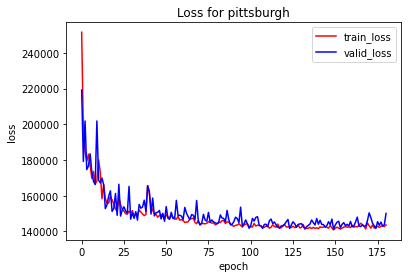

city: dearborn
Epoch: 01
	Train Loss: 2751911.331 | Val. Loss: 2075710.266
Epoch: 02
	Train Loss: 1887971.170 | Val. Loss: 1804487.312
Epoch: 03
	Train Loss: 1694493.632 | Val. Loss: 1690038.997
Epoch: 04
	Train Loss: 1634306.931 | Val. Loss: 1565720.622
Epoch: 05
	Train Loss: 1517544.168 | Val. Loss: 1523681.967
Epoch: 06
	Train Loss: 1470747.447 | Val. Loss: 1451999.855
Epoch: 07
	Train Loss: 1379902.193 | Val. Loss: 1497076.947
Epoch: 08
	Train Loss: 1313364.742 | Val. Loss: 1310223.870
Epoch: 09
	Train Loss: 1272097.664 | Val. Loss: 1283552.143
Epoch: 10
	Train Loss: 1247006.199 | Val. Loss: 1244069.702
Epoch: 11
	Train Loss: 1211770.249 | Val. Loss: 1220698.970
Epoch: 12
	Train Loss: 1181971.918 | Val. Loss: 1205968.692
Epoch: 13
	Train Loss: 1176824.422 | Val. Loss: 1198647.845
Epoch: 14
	Train Loss: 1193822.026 | Val. Loss: 1180129.738
Epoch: 15
	Train Loss: 1150556.572 | Val. Loss: 1161736.454
Epoch: 16
	Train Loss: 1113784.132 | Val. Loss: 1127862.553
Epoch: 17
	Train Loss: 10

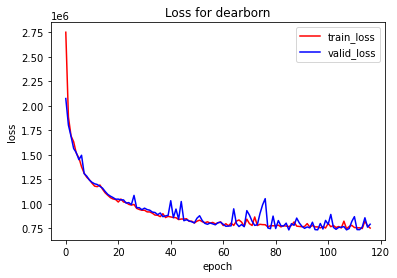

city: washington-dc
Epoch: 01
	Train Loss: 699857.647 | Val. Loss: 288905.382
Epoch: 02
	Train Loss: 239223.905 | Val. Loss: 232273.820
Epoch: 03
	Train Loss: 224232.673 | Val. Loss: 216925.273
Epoch: 04
	Train Loss: 222080.228 | Val. Loss: 217149.635
Epoch: 05
	Train Loss: 212177.582 | Val. Loss: 216137.770
Epoch: 06
	Train Loss: 211743.555 | Val. Loss: 206189.894
Epoch: 07
	Train Loss: 208802.782 | Val. Loss: 204934.070
Epoch: 08
	Train Loss: 204598.626 | Val. Loss: 213691.572
Epoch: 09
	Train Loss: 208071.619 | Val. Loss: 208712.735
Epoch: 10
	Train Loss: 209700.317 | Val. Loss: 206353.128
Epoch: 11
	Train Loss: 204958.189 | Val. Loss: 208308.770
Epoch: 12
	Train Loss: 206646.479 | Val. Loss: 205986.066
Epoch: 13
	Train Loss: 204408.770 | Val. Loss: 201683.648
Epoch: 14
	Train Loss: 202233.641 | Val. Loss: 201468.436
Epoch: 15
	Train Loss: 200517.093 | Val. Loss: 201851.507
Epoch: 16
	Train Loss: 200738.237 | Val. Loss: 198911.737
Epoch: 17
	Train Loss: 201674.464 | Val. Loss: 19964

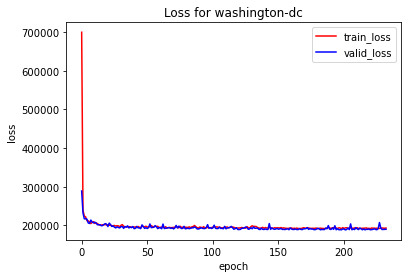

city: palo-alto
Epoch: 01
	Train Loss: 239356.775 | Val. Loss: 121360.064
Epoch: 02
	Train Loss: 93805.103 | Val. Loss: 107296.088
Epoch: 03
	Train Loss: 79073.660 | Val. Loss: 69153.334
Epoch: 04
	Train Loss: 67359.708 | Val. Loss: 77820.465
Epoch: 05
	Train Loss: 73090.448 | Val. Loss: 69325.779
Epoch: 06
	Train Loss: 64005.870 | Val. Loss: 63232.222
Epoch: 07
	Train Loss: 59178.670 | Val. Loss: 58562.049
Epoch: 08
	Train Loss: 55468.574 | Val. Loss: 53668.523
Epoch: 09
	Train Loss: 54305.700 | Val. Loss: 56578.472
Epoch: 10
	Train Loss: 52928.708 | Val. Loss: 52254.439
Epoch: 11
	Train Loss: 53479.161 | Val. Loss: 55748.054
Epoch: 12
	Train Loss: 55931.241 | Val. Loss: 55126.690
Epoch: 13
	Train Loss: 57059.098 | Val. Loss: 54861.699
Epoch: 14
	Train Loss: 58785.439 | Val. Loss: 62802.719
Epoch: 15
	Train Loss: 56297.440 | Val. Loss: 57282.167
Epoch: 16
	Train Loss: 61124.059 | Val. Loss: 71164.269
Epoch: 17
	Train Loss: 61972.833 | Val. Loss: 60013.921
Epoch: 18
	Train Loss: 60179.

/tmp/ipykernel_9906/3476577009.py:27: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(model.parameters(), clip)


Epoch: 91
	Train Loss: 68995.427 | Val. Loss: 102033.716
Epoch: 92
	Train Loss: 135517.924 | Val. Loss: 112325.125
Epoch: 93
	Train Loss: 88518.966 | Val. Loss: 59498.160
Epoch: 94
	Train Loss: 53441.170 | Val. Loss: 48481.655
Epoch: 95
	Train Loss: 46676.972 | Val. Loss: 45603.700
Epoch: 96
	Train Loss: 46227.687 | Val. Loss: 46393.780
Epoch: 97
	Train Loss: 46718.442 | Val. Loss: 46697.168
Epoch: 98
	Train Loss: 46054.965 | Val. Loss: 44979.640
Epoch: 99
	Train Loss: 45437.985 | Val. Loss: 45207.795
Epoch: 100
	Train Loss: 45644.783 | Val. Loss: 46037.055
Epoch: 101
	Train Loss: 45579.000 | Val. Loss: 45012.748
Epoch: 102
	Train Loss: 45412.282 | Val. Loss: 44931.587
Epoch: 103
	Train Loss: 46382.823 | Val. Loss: 46374.689
Epoch: 104
	Train Loss: 45697.307 | Val. Loss: 44360.942
Epoch: 105
	Train Loss: 45318.821 | Val. Loss: 45696.433
Epoch: 106
	Train Loss: 45392.386 | Val. Loss: 44221.440
Epoch: 107
	Train Loss: 44757.579 | Val. Loss: 45605.430
Epoch: 108
	Train Loss: 45531.370 | V

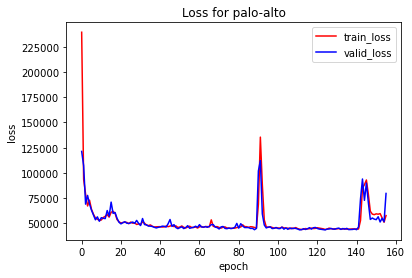

CPU times: user 5h 43min 50s, sys: 24min 20s, total: 6h 8min 10s
Wall time: 6h 8min 33s


In [17]:
%%time

batch_size = 128
n_epochs = 250
clip = 1

all_cities_best_train_loss = [float('inf')] * len(cities)
all_cities_best_valid_loss = [float('inf')] * len(cities)
city_index = 0

#train city models
for city in cities:
    train_losses = []
    valid_losses = []
    
    early_stop_counter = 0
    
    
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, drop_last = True)
    
    best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            pickle.dump(model, open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00' + city, 'wb'))
            all_cities_best_train_loss[city_index] = train_loss
            all_cities_best_valid_loss[city_index] = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > early_stop_criteria:
                print("Stopped early at epoch " + str(epoch) + " due to overfit")
                break
            

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    
    city_index += 1
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Total training time for this city is: {epoch_mins}m {epoch_secs}s')
    #plot city loss
    plt.title("Loss for " + city)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(valid_losses, color ="blue", label = "valid_loss")
    plt.legend()
    plt.show()


In [1]:
all_cities_best_train_loss = np.array(all_cities_best_train_loss)
all_cities_best_valid_loss = np.array(all_cities_best_valid_loss)
np.set_printoptions(precision=2)

print(*cities, sep = ", ")
print(f'Best Train MSE Loss: {all_cities_best_train_loss} ')
print(f'Best Valid MSE Loss: {all_cities_best_valid_loss} ')

NameError: name 'np' is not defined

RuntimeError: CUDA out of memory. Tried to allocate 4.48 GiB (GPU 0; 7.93 GiB total capacity; 4.56 GiB already allocated; 2.41 GiB free; 4.71 GiB reserved in total by PyTorch)

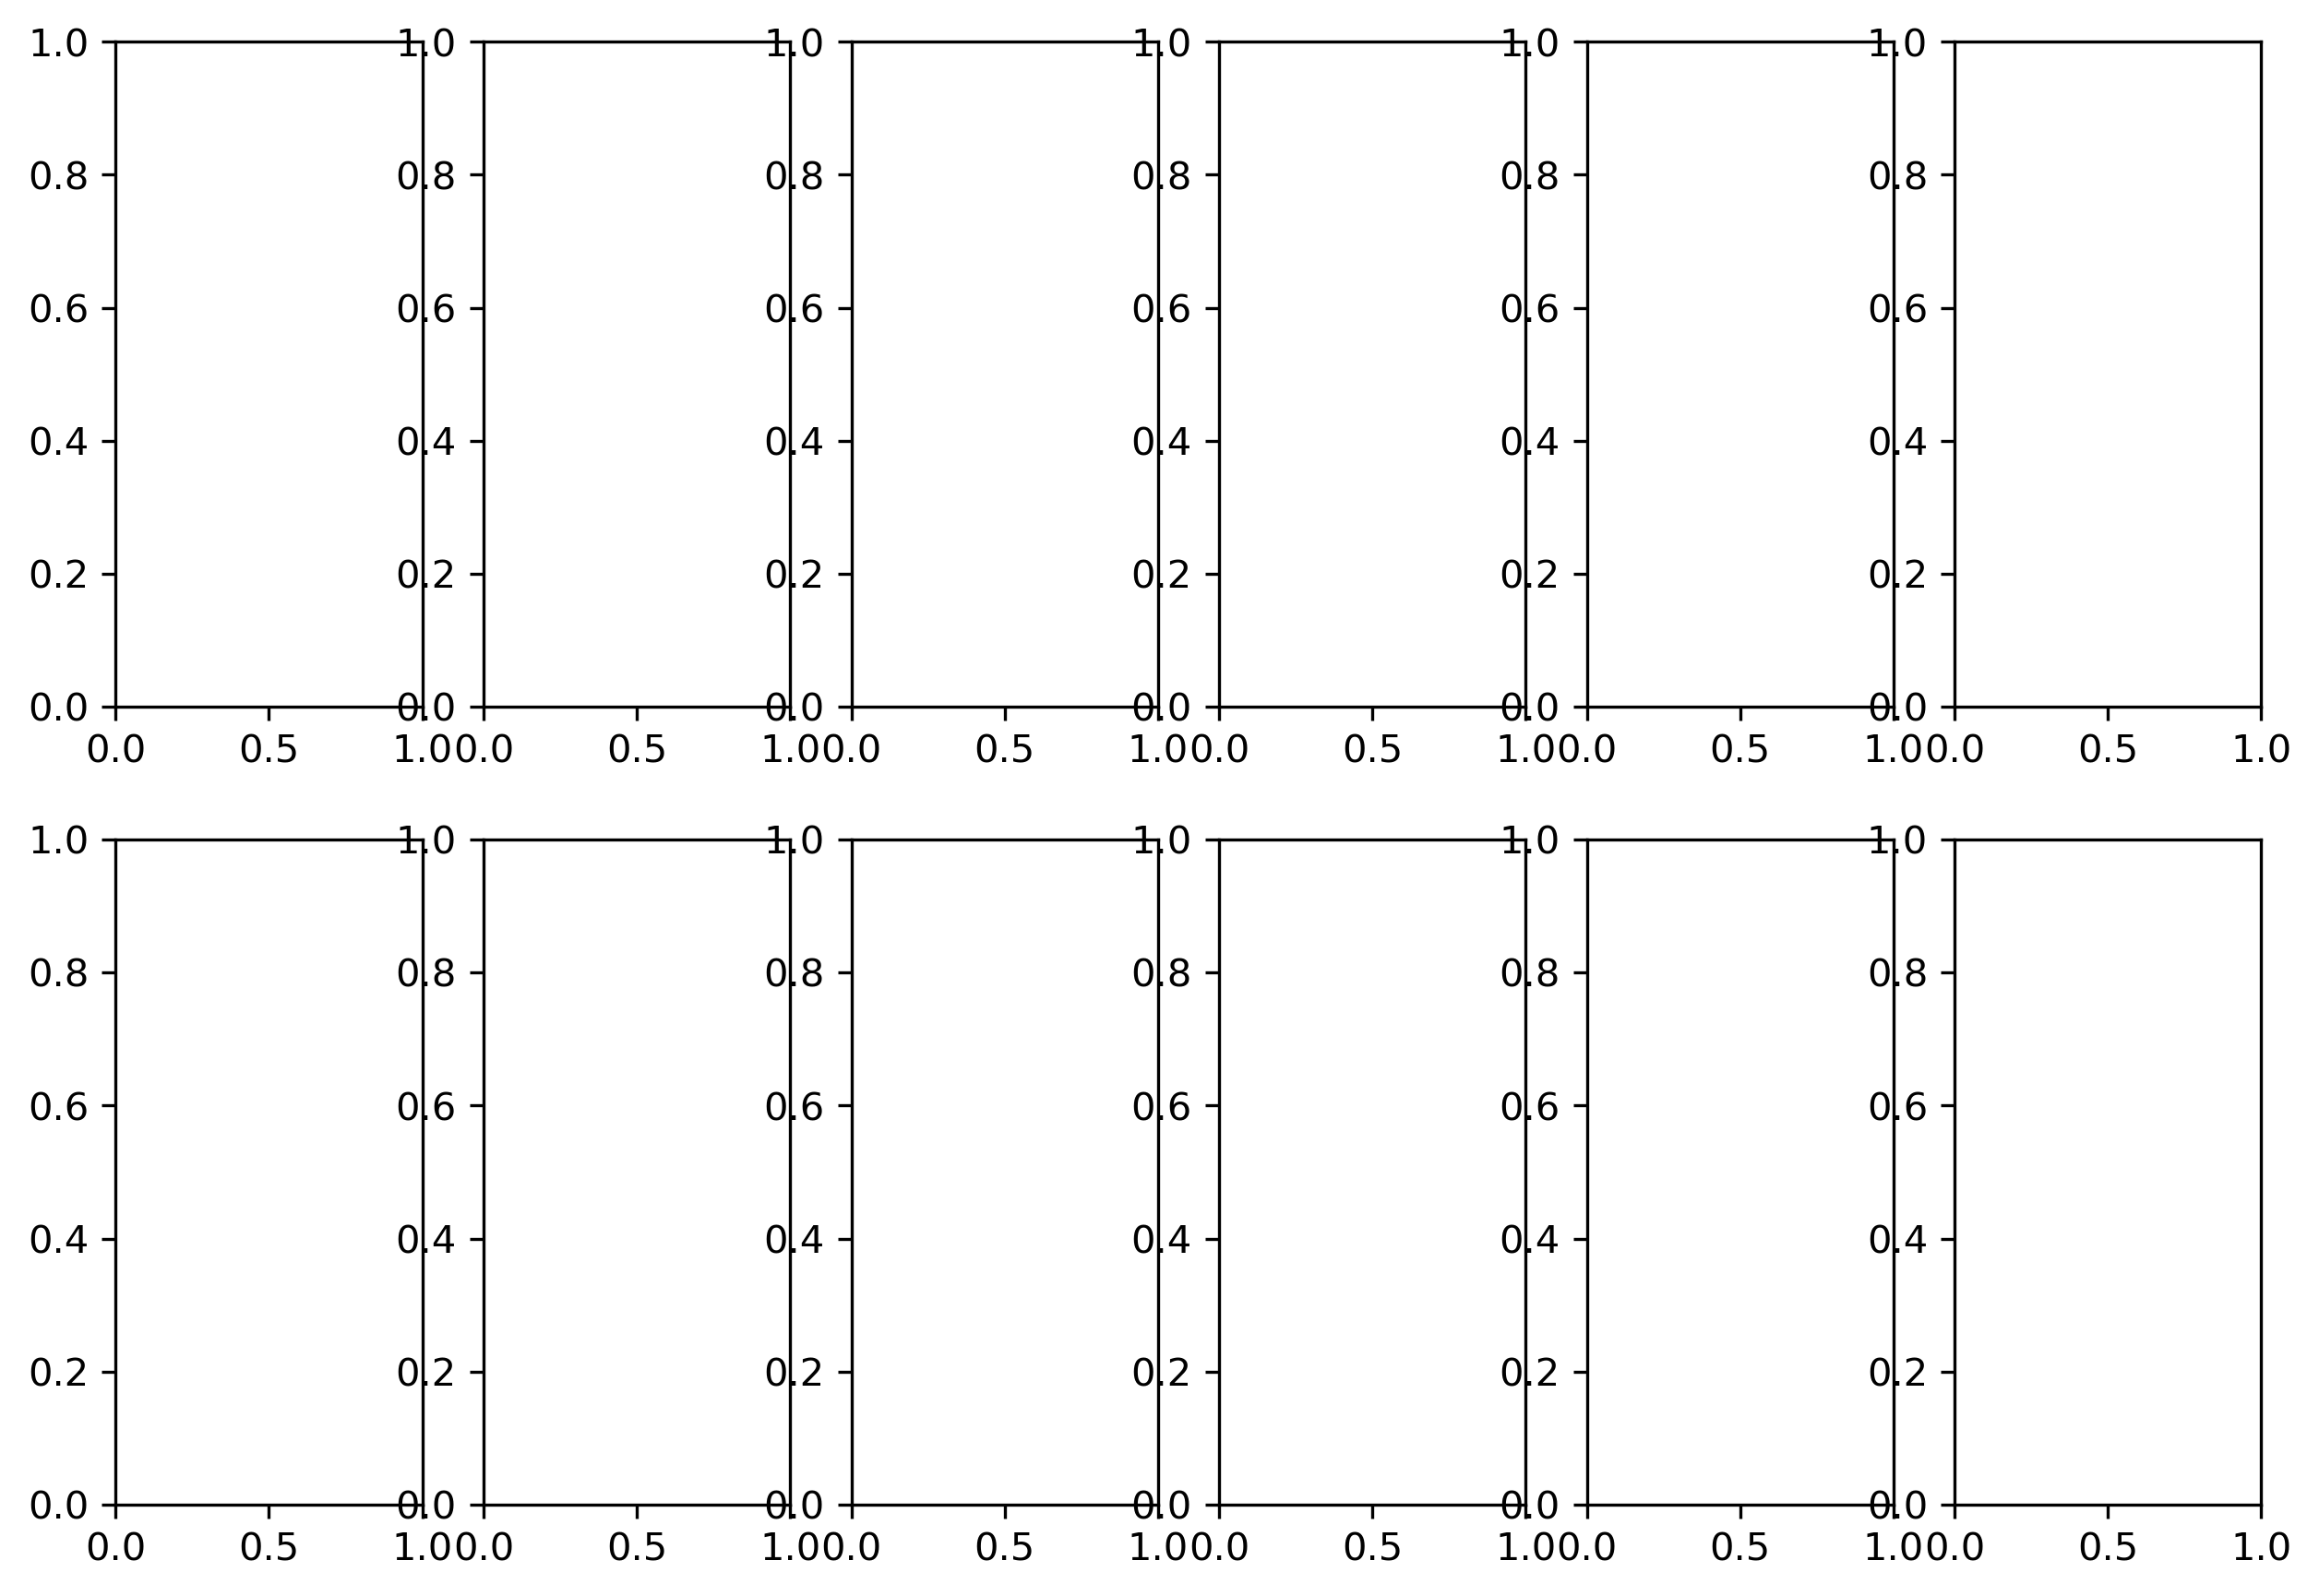

In [21]:
cols = np.array(['v' + str(i) for i in range(120)])
num_layers = 2 #change by hand to pick model
fig, axs = plt.subplots(2,6, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
#fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(city))):

    #loading model
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00' + city, 'rb'))
    
    #get the training dataset/ return inputs, ouputs
    train_dataset= get_city_trajectories(city = city, split = 'train')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = load_pred(torch.from_numpy(train_dataset[0]).float().to(device),torch.zeros(num_layers,len(train_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city.upper() + ' Sample_1',fontsize =7)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .6)
    axs[i].legend(loc='best')
    

    sample = random.randint(0,len(preds_numpy)) 
    samp_2_truth = truth_reshaped[sample].reshape(60,2)
    samp_2_pred = preds_numpy[sample].reshape(60,2)
    samp_2_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i+6].set_title(city.upper() + ' Sample_2',fontsize =7)
    axs[i+6].xaxis.set_ticks([])
    axs[i+6].yaxis.set_ticks([])
    axs[i+6].scatter(samp_2_inp[:,0], samp_2_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i+6].scatter(samp_2_truth[:,0], samp_2_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i+6].scatter(samp_2_pred[:,0], samp_2_pred[:,1], color = 'green', label= 'pred', alpha= .6)
    axs[i+6].legend(loc='best')

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []

for city in cities:
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device), torch.zeros(num_layers,len(test_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [ ]:
all_predictions

In [ ]:
all_predictions.to_csv('lstm_out_2_t00.csv', index=False)

In [ ]:
pd.read_csv('lstm_out_2_t00.csv')

#### 2. "Teacher-forcing" = 0.0 & 2 layers & drop_out = 0.3

In [22]:
INPUT_DIM = (50,2)
OUTPUT_DIM = 2
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(2, 512, num_layers=2, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (lstm): LSTM(2, 512, num_layers=2, dropout=0.3)
    (fc_out): Linear(in_features=512, out_features=2, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,317,058 trainable parameters


In [25]:
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [26]:
criterion = nn.MSELoss()

In [27]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        src, trg = batch
        
        src = src.to(device)
        src = src.float()
        trg = trg.to(device)
        trg = trg.float()
            
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [batch size, trg len, trg feat]
        #output = [batch size, trg len, out dim]    
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [28]:
def evaluate(model, val_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()
            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(val_loader)


In [29]:
# function that tells how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
%%time

batch_size = 128
n_epochs = 250
clip = 1

all_cities_best_train_loss = [float('inf')] * len(cities)
all_cities_best_valid_loss = [float('inf')] * len(cities)
city_index = 0

#train city models
for city in cities:
    train_losses = []
    valid_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 30
    
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, drop_last = True)
    
    best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            pickle.dump(model, open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'wb'))
            all_cities_best_train_loss[city_index] = train_loss
            all_cities_best_valid_loss[city_index] = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > early_stop_criteria:
                print("Stopped early at epoch " + str(epoch) + " due to overfit")
                break
            

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    
    city_index += 1
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Total training time for this city is: {epoch_mins}m {epoch_secs}s')
    #plot city loss
    plt.title("Loss for " + city)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(valid_losses, color ="blue", label = "valid_loss")
    plt.legend()
    plt.show()


city: austin
Epoch: 01
	Train Loss: 1876275.718 | Val. Loss: 1642738.226
Epoch: 02
	Train Loss: 1482983.526 | Val. Loss: 1345916.286
Epoch: 03
	Train Loss: 1238546.960 | Val. Loss: 1147668.749
Epoch: 04
	Train Loss: 1084498.921 | Val. Loss: 1030392.413
Epoch: 05
	Train Loss: 984175.527 | Val. Loss: 947022.947
Epoch: 06
	Train Loss: 905409.757 | Val. Loss: 877029.670
Epoch: 07
	Train Loss: 838338.181 | Val. Loss: 812475.271
Epoch: 08
	Train Loss: 779905.491 | Val. Loss: 759396.203
Epoch: 09
	Train Loss: 725882.393 | Val. Loss: 704380.764
Epoch: 10
	Train Loss: 672354.192 | Val. Loss: 655620.417
Epoch: 11
	Train Loss: 623205.062 | Val. Loss: 603788.511
Epoch: 12
	Train Loss: 572248.730 | Val. Loss: 554957.999
Epoch: 13
	Train Loss: 527646.513 | Val. Loss: 515707.921
Epoch: 14
	Train Loss: 491074.631 | Val. Loss: 481938.076
Epoch: 15
	Train Loss: 455403.095 | Val. Loss: 444187.791
Epoch: 16
	Train Loss: 419222.317 | Val. Loss: 411970.774
Epoch: 17
	Train Loss: 393173.201 | Val. Loss: 3877

KeyboardInterrupt: 

In [31]:
all_cities_best_train_loss = np.array(all_cities_best_train_loss)
all_cities_best_valid_loss = np.array(all_cities_best_valid_loss)
np.set_printoptions(precision=2)

print(*cities, sep = ", ")
print(f'Best Train MSE Loss: {all_cities_best_train_loss} ')
print(f'Best Valid MSE Loss: {all_cities_best_valid_loss} ')

austin, miami, pittsburgh, dearborn, washington-dc, palo-alto
Best Train MSE Loss: [43645.61      inf      inf      inf      inf      inf] 
Best Valid MSE Loss: [41386.47      inf      inf      inf      inf      inf] 


In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
num_layers = 2 #change by hand to pick model
fig, axs = plt.subplots(2,6, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
#fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(city))):

    #loading model
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'rb'))
    
    #get the training dataset/ return inputs, ouputs
    train_dataset= get_city_trajectories(city = city, split = 'train')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = load_pred(torch.from_numpy(train_dataset[0]).to(device),torch.zeros(num_layers,len(train_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city.upper() + ' Sample_1',fontsize =7)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .6)
    axs[i].legend(loc='best')
    

    sample = random.randint(0,len(preds_numpy)) 
    samp_2_truth = truth_reshaped[sample].reshape(60,2)
    samp_2_pred = preds_numpy[sample].reshape(60,2)
    samp_2_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i+6].set_title(city.upper() + ' Sample_2',fontsize =7)
    axs[i+6].xaxis.set_ticks([])
    axs[i+6].yaxis.set_ticks([])
    axs[i+6].scatter(samp_2_inp[:,0], samp_2_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i+6].scatter(samp_2_truth[:,0], samp_2_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i+6].scatter(samp_2_pred[:,0], samp_2_pred[:,1], color = 'green', label= 'pred', alpha= .6)
    axs[i+6].legend(loc='best')

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []

for city in cities:
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device), torch.zeros(num_layers,len(test_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [ ]:
all_predictions

In [ ]:
all_predictions.to_csv('lstm_out_2_t00_d.csv', index=False)

In [ ]:
pd.read_csv('lstm_out_2_t00_d.csv')

#### 3. "Teacher-forcing" = 0.0 & 3 layers & drop_out = 0.3

In [32]:
INPUT_DIM = (50,2)
OUTPUT_DIM = 2
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

KeyboardInterrupt: 

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        src, trg = batch
        
        src = src.to(device)
        src = src.float()
        trg = trg.to(device)
        trg = trg.float()
            
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [batch size, trg len, trg feat]
        #output = [batch size, trg len, out dim]    
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()
            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(val_loader)


In [ ]:
# function that tells how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
%%time

batch_size = 128
n_epochs = 250
clip = 1

all_cities_best_train_loss = [float('inf')] * len(cities)
all_cities_best_valid_loss = [float('inf')] * len(cities)
city_index = 0

#train city models
for city in cities:
    train_losses = []
    valid_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 30
    
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, drop_last = True)
    
    best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            pickle.dump(model, open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'wb'))
            all_cities_best_train_loss[city_index] = train_loss
            all_cities_best_valid_loss[city_index] = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > early_stop_criteria:
                print("Stopped early at epoch " + str(epoch) + " due to overfit")
                break
            

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    
    city_index += 1
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Total training time for this city is: {epoch_mins}m {epoch_secs}s')
    #plot city loss
    plt.title("Loss for " + city)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(valid_losses, color ="blue", label = "valid_loss")
    plt.legend()
    plt.show()


In [ ]:
all_cities_best_train_loss = np.array(all_cities_best_train_loss)
all_cities_best_valid_loss = np.array(all_cities_best_valid_loss)
np.set_printoptions(precision=2)

print(*cities, sep = ", ")
print(f'Best Train MSE Loss: {all_cities_best_train_loss} ')
print(f'Best Valid MSE Loss: {all_cities_best_valid_loss} ')

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
num_layers = 3 #change by hand to pick model
fig, axs = plt.subplots(2,6, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
#fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(city))):

    #loading model
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'rb'))
    
    #get the training dataset/ return inputs, ouputs
    train_dataset= get_city_trajectories(city = city, split = 'train')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = load_pred(torch.from_numpy(train_dataset[0]).to(device),torch.zeros(num_layers,len(train_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city.upper() + ' Sample_1',fontsize =7)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .6)
    axs[i].legend(loc='best')
    

    sample = random.randint(0,len(preds_numpy)) 
    samp_2_truth = truth_reshaped[sample].reshape(60,2)
    samp_2_pred = preds_numpy[sample].reshape(60,2)
    samp_2_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i+6].set_title(city.upper() + ' Sample_2',fontsize =7)
    axs[i+6].xaxis.set_ticks([])
    axs[i+6].yaxis.set_ticks([])
    axs[i+6].scatter(samp_2_inp[:,0], samp_2_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i+6].scatter(samp_2_truth[:,0], samp_2_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i+6].scatter(samp_2_pred[:,0], samp_2_pred[:,1], color = 'green', label= 'pred', alpha= .6)
    axs[i+6].legend(loc='best')

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []

for city in cities:
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t00_d_' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device), torch.zeros(num_layers,len(test_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [ ]:
all_predictions

In [ ]:
all_predictions.to_csv('lstm_out_3_t00_d.csv', index=False)

In [ ]:
pd.read_csv('lstm_out_3_t00_d.csv')

#### 4. "Teacher-forcing" = 0.5 & 3 layers & drop_out = 0.3

In [ ]:
INPUT_DIM = (50,2)
OUTPUT_DIM = 2
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        src, trg = batch
        
        src = src.to(device)
        src = src.float()
        trg = trg.to(device)
        trg = trg.float()
            
        optimizer.zero_grad()
        
        output = model(src, trg, 0.5) # teacher forcing is 0.5 here
        
        #trg = [batch size, trg len, trg feat]
        #output = [batch size, trg len, out dim]    
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()
            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(val_loader)


In [ ]:
# function that tells how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
%%time

batch_size = 128
n_epochs = 250
clip = 1

all_cities_best_train_loss = [float('inf')] * len(cities)
all_cities_best_valid_loss = [float('inf')] * len(cities)
city_index = 0

#train city models
for city in cities:
    train_losses = []
    valid_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 30
    
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, drop_last = True)
    
    best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            pickle.dump(model, open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t05_d_' + city, 'wb'))
            all_cities_best_train_loss[city_index] = train_loss
            all_cities_best_valid_loss[city_index] = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > early_stop_criteria:
                print("Stopped early at epoch " + str(epoch) + " due to overfit")
                break
            

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    
    city_index += 1
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Total training time for this city is: {epoch_mins}m {epoch_secs}s')
    #plot city loss
    plt.title("Loss for " + city)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(valid_losses, color ="blue", label = "valid_loss")
    plt.legend()
    plt.show()


In [ ]:
all_cities_best_train_loss = np.array(all_cities_best_train_loss)
all_cities_best_valid_loss = np.array(all_cities_best_valid_loss)
np.set_printoptions(precision=2)

print(*cities, sep = ", ")
print(f'Best Train MSE Loss: {all_cities_best_train_loss} ')
print(f'Best Valid MSE Loss: {all_cities_best_valid_loss} ')

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
num_layers = 3 #change by hand to pick model
fig, axs = plt.subplots(2,6, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
#fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(city))):

    #loading model
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t05_d_' + city, 'rb'))
    
    #get the training dataset/ return inputs, ouputs
    train_dataset= get_city_trajectories(city = city, split = 'train')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = load_pred(torch.from_numpy(train_dataset[0]).to(device),torch.zeros(num_layers,len(train_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city.upper() + ' Sample_1',fontsize =7)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .6)
    axs[i].legend(loc='best')
    

    sample = random.randint(0,len(preds_numpy)) 
    samp_2_truth = truth_reshaped[sample].reshape(60,2)
    samp_2_pred = preds_numpy[sample].reshape(60,2)
    samp_2_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i+6].set_title(city.upper() + ' Sample_2',fontsize =7)
    axs[i+6].xaxis.set_ticks([])
    axs[i+6].yaxis.set_ticks([])
    axs[i+6].scatter(samp_2_inp[:,0], samp_2_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i+6].scatter(samp_2_truth[:,0], samp_2_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i+6].scatter(samp_2_pred[:,0], samp_2_pred[:,1], color = 'green', label= 'pred', alpha= .6)
    axs[i+6].legend(loc='best')

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [ ]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []

for city in cities:
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + '_t05_d' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device), torch.zeros(num_layers,len(test_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [ ]:
all_predictions

In [ ]:
all_predictions.to_csv('lstm_out_3_t05_d.csv', index=False)

In [ ]:
pd.read_csv('lstm_out_3_t05_d.csv')

In [33]:
for i, batch in enumerate(train_loader):
    print(i)

    src,tar = batch
    src = src.to(device)
    tar = tar.to(device)
    print(tar)
    break

0
tensor([[[ -371.9679,   869.7135],
         [ -371.9676,   869.7160],
         [ -371.9672,   869.7175],
         ...,
         [ -372.1832,   867.6788],
         [ -372.2095,   867.3911],
         [ -372.2322,   867.1345]],

        [[ -226.9242,   422.6842],
         [ -227.3633,   421.5030],
         [ -227.7048,   420.3831],
         ...,
         [ -239.5730,   380.7581],
         [ -239.6217,   380.6076],
         [ -239.6579,   380.4923]],

        [[ 2087.2883, -1648.5375],
         [ 2087.5382, -1647.8618],
         [ 2087.7971, -1647.1800],
         ...,
         [ 2103.3735, -1606.6444],
         [ 2103.5254, -1606.2513],
         [ 2103.6430, -1605.9456]],

        ...,

        [[  880.5447, -1669.9484],
         [  881.1337, -1670.2430],
         [  881.7357, -1670.5383],
         ...,
         [  925.9316, -1687.6492],
         [  926.3943, -1687.8332],
         [  926.7520, -1687.9751]],

        [[ -130.8418,  -761.8123],
         [ -131.5528,  -761.5780],
         [